<a href="https://colab.research.google.com/github/nguyenvuong1309/Do-an-lap-trinh-an-toan/blob/main/BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import pandas as pd
from numpy import zeros, newaxis
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional,Activation
import matplotlib.pyplot as plt
import csv


Mounted at /content/drive


In [2]:
csv_file_path = '/content/drive/MyDrive/Colab/dataset/text_dataset.csv'
df = pd.read_csv(csv_file_path,sep=",")

In [3]:
dataset = df

In [4]:
print(dataset.head())

   Index                                                  1  label
0      0  1 150200/dirent_uri.c memset 405\nconst char *...      0
1      1  2 79848/CWE134_Uncontrolled_Format_String__cha...      0
2      2  3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...      0
3      3  4 151133/utils.c strcmp 737\nint avformat_open...      0
4      4  5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...     32


In [5]:
dataset = dataset[['1','label']]
dataset.head()

,1,label
0,1 150200/dirent_uri.c memset 405\nconst char *...,0
1,2 79848/CWE134_Uncontrolled_Format_String__cha...,0
2,3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...,0
3,4 151133/utils.c strcmp 737\nint avformat_open...,0
4,5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...,32


In [6]:
print(dataset['label'].unique())
print(len(dataset['label'].unique()))

[ 0 32  4 10 20 36  3  1 12 25 15 34 16 11  2 14 35 38  9 29  7 18 37 21
 22 23  5  8 17 31 39 33 28 30 19 40 26 13 24 27  6]
41


# Visiualize dataset

In [7]:
len_dataset = int(dataset.shape[0])
y_dataset = []
for i in range(41):
  number = int(dataset[dataset['label'] == i].shape[0])
  y_dataset.append(number)
y_dataset = np.array(y_dataset)


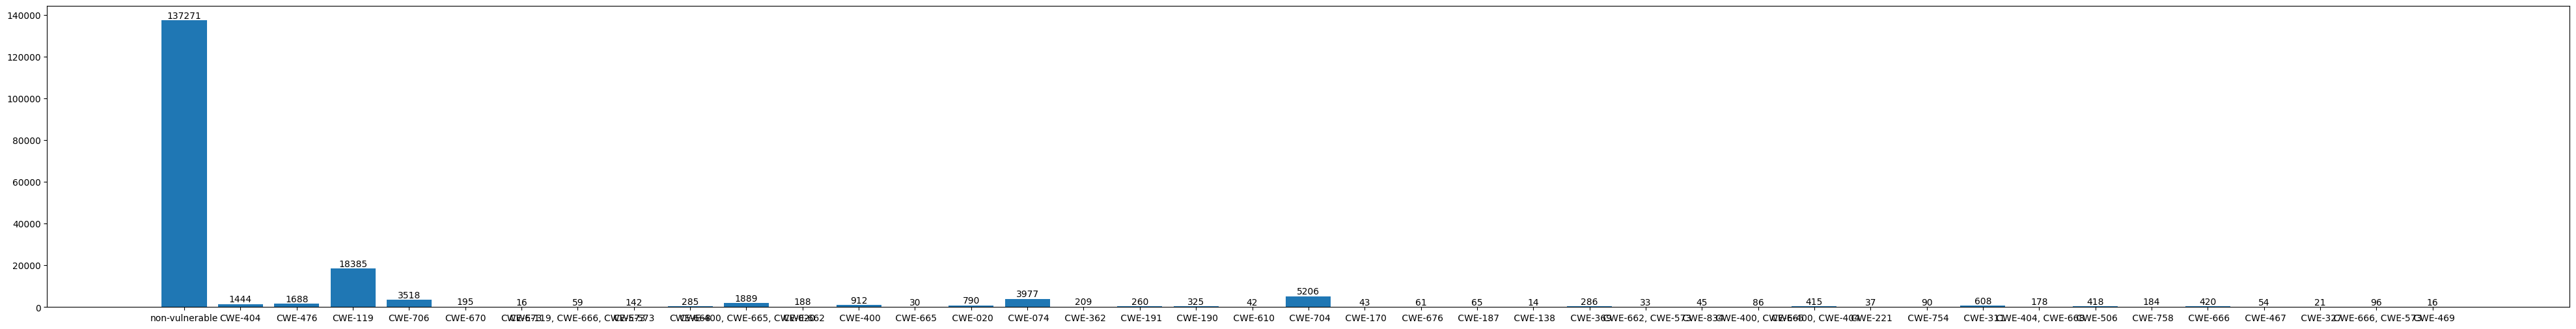

In [8]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe, y_dataset, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

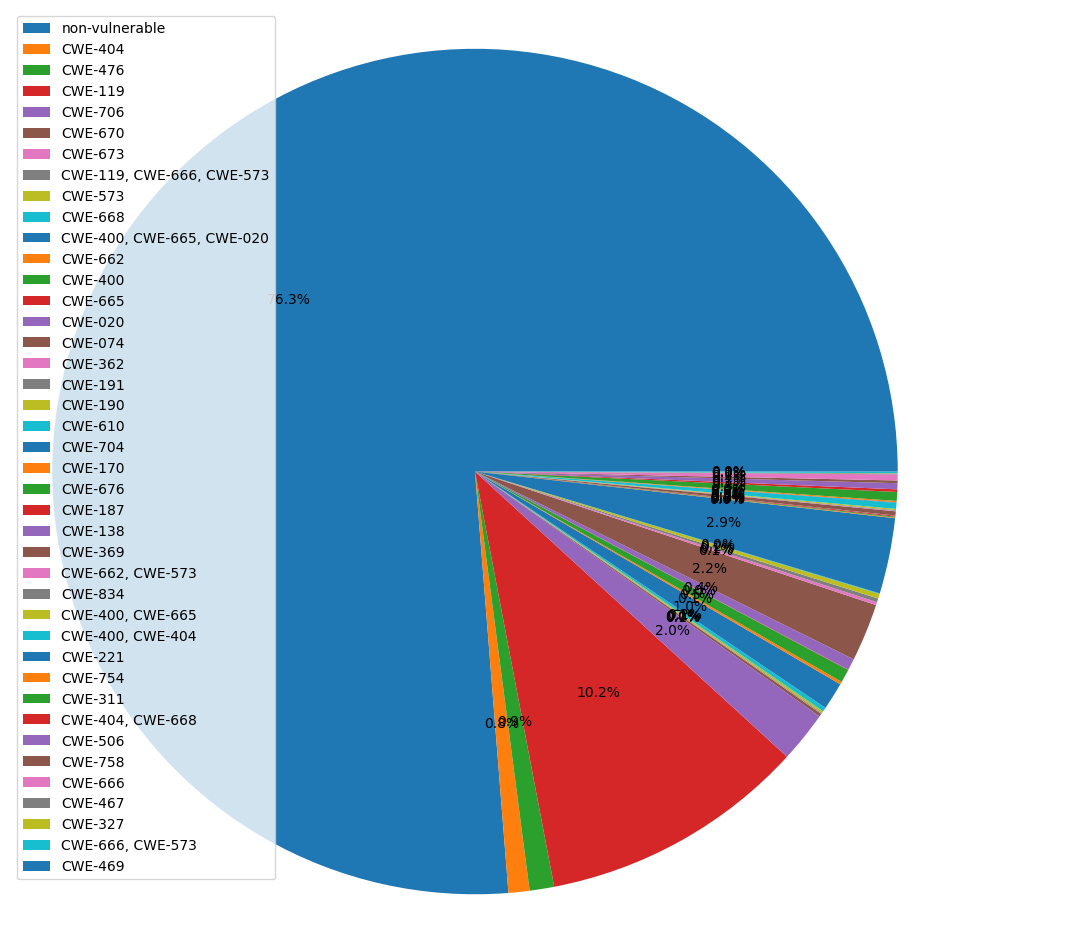

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y_dataset, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


In [10]:
a = len(dataset[dataset['label'] == 0])
b = len(dataset[dataset['label'] != 0])
print(a * 100.0 / (a + b))
print(b * 100.0 / (a + b))

76.26124299309448
23.738757006905516


# Data augmentation

In [11]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.1 MB/s eta 0:00:00


In [12]:
import nlpaug.augmenter.char as nac

test_sentence = 'I went Shopping Today, and my trolly was filled with Bananas. I also had food at burgur palace'

aug = nac.KeyboardAug(name='Keyboard_Aug', aug_char_min=1, aug_char_max=10, aug_char_p=0.3, aug_word_p=0.3,
                      aug_word_min=1, aug_word_max=10, stopwords=None, tokenizer=None, reverse_tokenizer=None,
                      include_special_char=True, include_numeric=True, include_upper_case=True, lang='en', verbose=0,
                      stopwords_regex=None, model_path=None, min_char=4)

test_sentence_aug = aug.augment(test_sentence)
print(test_sentence_aug)

['I weJ$ Shopping Today, and my trpllt was filled #*th Bananas. I aixo had vo9d at burgur Lalqce']


In [13]:
dataset_aug = dataset[:]
for i in range(1,41):
  temp = []
  for s in dataset[dataset['label'] == i]['1']:
    temp.append(s)
    temp.append(s)
    temp.append(s)
  temp_aug = aug.augment(temp)
  temp_pandas = pd.DataFrame(temp_aug)
  temp_pandas.columns = ['1']
  temp_pandas['label'] = int(i)
  dataset_aug = pd.concat([dataset_aug, temp_pandas], axis=0, ignore_index=True)
print(dataset_aug.shape)

(308191, 2)


In [14]:
len_dataset_aug = int(dataset_aug.shape[0])
y_dataset_aug = np.array([])
for i in range(41):
  number = int(dataset_aug[dataset_aug['label'] == i].shape[0])
  y_dataset_aug = np.insert(y_dataset_aug,len(y_dataset_aug),number)


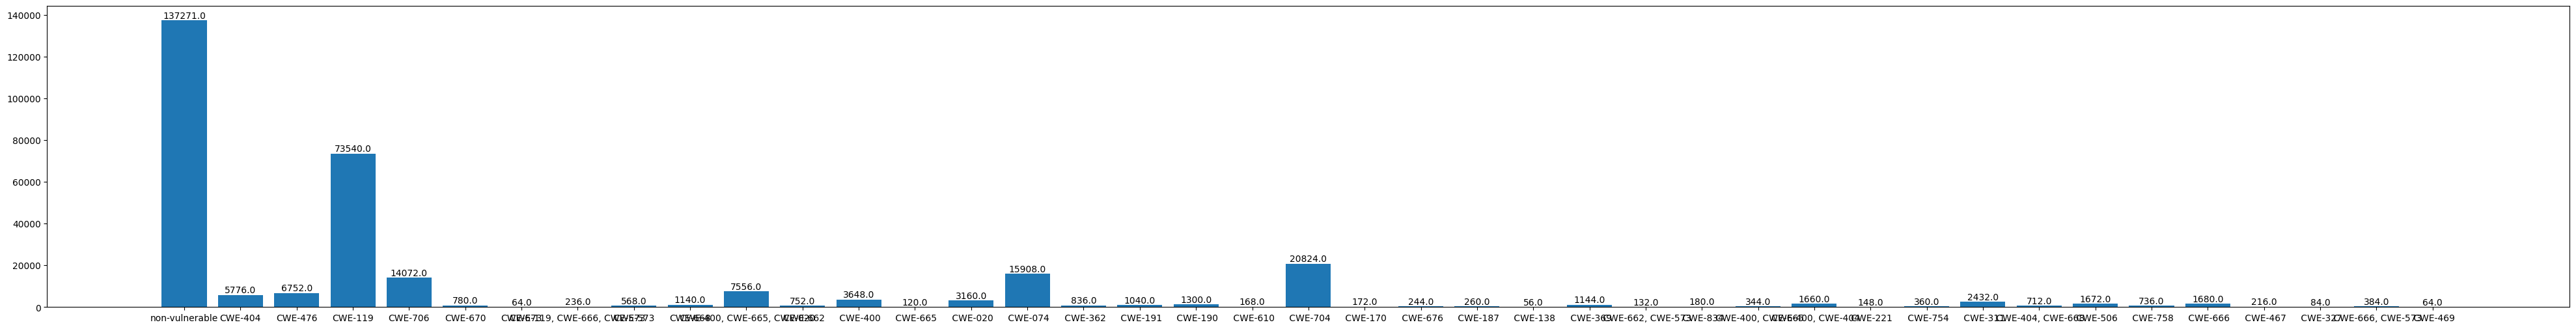

In [15]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe,y_dataset_aug , label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

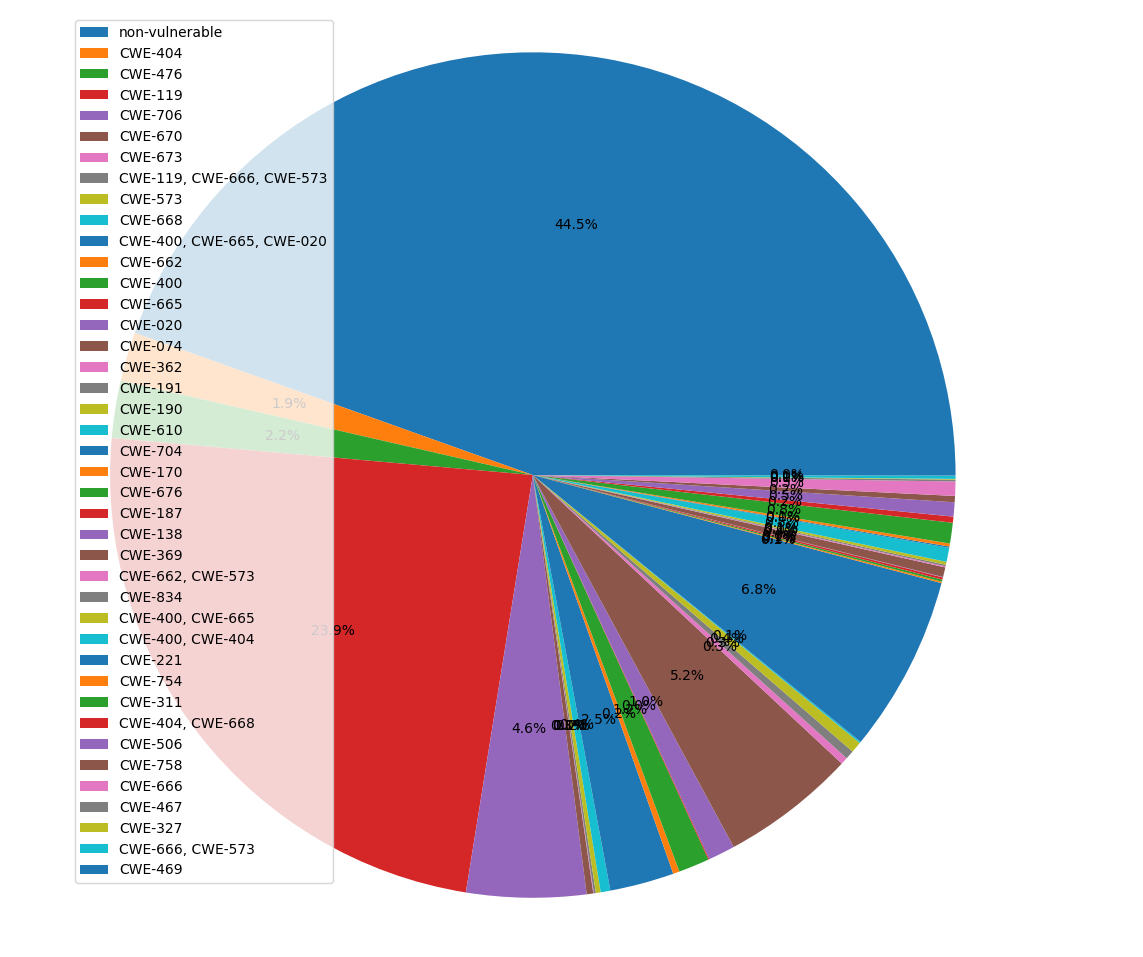

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y_dataset_aug, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


In [17]:
a = len(dataset_aug[dataset_aug['label'] == 0])
b = len(dataset_aug[dataset_aug['label'] != 0])
print(a * 100.0 / (a + b))
print(b * 100.0 / (a + b))

44.54088536005269
55.45911463994731


# Train Test split

In [18]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.4


train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()
for i in range(41):
  len_dataset_aug_byCWE = int(dataset_aug[dataset_aug['label'] == i].shape[0])

  temp_train = dataset_aug[dataset_aug['label'] == i][:int(TRAIN_RATIO * len_dataset_aug_byCWE)]
  train_dataset = pd.concat([temp_train, train_dataset], axis=0, ignore_index=True)

  temp_test = dataset_aug[dataset_aug['label'] == i][int(TRAIN_RATIO * len_dataset_aug_byCWE) : int(len_dataset_aug_byCWE)]
  test_dataset = pd.concat([temp_test, test_dataset], axis=0, ignore_index=True)

print(train_dataset['label'].value_counts())
print(test_dataset['label'].value_counts())

0     82362
3     44124
20    12494
15     9544
4      8443
10     4533
2      4051
1      3465
12     2188
14     1896
32     1459
36     1008
34     1003
29      996
18      780
25      686
9       684
17      624
16      501
5       468
11      451
35      441
33      427
8       340
39      230
31      216
28      206
23      156
22      146
7       141
37      129
27      108
21      103
19      100
30       88
26       79
13       72
38       50
6        38
40       38
24       33
Name: label, dtype: int64
0     54909
3     29416
20     8330
15     6364
4      5629
10     3023
2      2701
1      2311
12     1460
14     1264
32      973
36      672
34      669
29      664
18      520
25      458
9       456
17      416
16      335
5       312
11      301
35      295
33      285
8       228
39      154
31      144
28      138
23      104
22       98
7        95
37       87
27       72
21       69
19       68
30       60
26       53
13       48
38       34
6        26
40       26
24

In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [20]:
train_dataset = train_dataset.sample(frac=1, replace=True, random_state=1)
test_dataset = test_dataset.sample(frac=1, replace=True, random_state=1)

In [21]:
print(train_dataset.shape)
print(test_dataset.shape)

(184901, 2)
(123290, 2)


# Model preparation

In [22]:
#<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
text_data = train_dataset['1'].values
tensor = tf.data.Dataset.from_tensor_slices(text_data)

In [23]:
tensor

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [24]:

VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tensor)

In [25]:
train_dataset['1']

128037    33451 118029/CWE78_OS_Command_Injection__char_...
5192      48004 99713/CWE401_Memory_Leak__malloc_realloc...
50057     68090 90I0@ / CWE23_Relative_Path_Traversal__c...
109259    8845 79129/CWE134_Uncontrolled_Format_String__...
73349     13484 72287 / CWE122_Heap_Based_Buffer_Overflo...
                                ...                        
71570     7212 685I0 / CWE122_Heap_Based_Buffer_Overflow...
161148    76949 74074/CWE124_Buffer_Underwrite__char_dec...
77210     2u459 71898 / FWE121_Teal_Bas@d_Bufder_(verEKo...
138851    47585 111291/CWE690_NULL_Deref_From_Return__in...
156713    71126 85436/CWE191_Integer_Underflow__int_fget...
Name: 1, Length: 184901, dtype: object

In [26]:
train_dataset

,1,label
128037,33451 118029/CWE78_OS_Command_Injection__char_...,0
5192,48004 99713/CWE401_Memory_Leak__malloc_realloc...,29
50057,68090 90I0@ / CWE23_Relative_Path_Traversal__c...,4
109259,8845 79129/CWE134_Uncontrolled_Format_String__...,0
73349,13484 72287 / CWE122_Heap_Based_Buffer_Overflo...,3
...,...,...
71570,7212 685I0 / CWE122_Heap_Based_Buffer_Overflow...,3
161148,76949 74074/CWE124_Buffer_Underwrite__char_dec...,0
77210,2u459 71898 / FWE121_Teal_Bas@d_Bufder_(verEKo...,3
138851,47585 111291/CWE690_NULL_Deref_From_Return__in...,0


In [27]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '0', 'if', 'data', '1', 'char', 'void', '100',
       'service', 'i', 'int', 'sizeof', 'd', 's', 'recvresult', 'null',
       'line', 'datalen', '2'], dtype='<U559')

In [28]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
X_train = train_dataset['1']
y_train = train_dataset['label']
y_train = tf.keras.utils.to_categorical(y_train, num_classes=41)

In [31]:
print(X_train.shape)
print(y_train.shape)

(184901,)
(184901, 41)


In [32]:
history = model.fit(X_train,y_train, epochs=1,
                    # validation_data=test_dataset,
                    # validation_steps=30
                    )

5779/5779 [==============================] - 560s 94ms/step - loss: 0.4997 - accuracy: 0.8834


In [33]:
X_test = test_dataset['1']
y_test = test_dataset['label']
y_test = tf.keras.utils.to_categorical(y_test, num_classes=41)

In [34]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

3853/3853 [==============================] - 107s 27ms/step - loss: 0.0882 - accuracy: 0.9835
Test Loss: 0.08820933848619461
Test Accuracy: 0.9835347533226013


In [35]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)
print(y_test.shape)
print(y_test)

3853/3853 [==============================] - 99s 25ms/step
(123290, 41)
[[9.9967635e-01 2.9711600e-04 8.0324855e-07 ... 5.7097799e-11
  9.2337120e-07 2.9942954e-11]
 [9.9993384e-01 4.4612119e-05 4.0209625e-07 ... 7.9982014e-11
  4.2760945e-07 4.7756070e-11]
 [3.9269796e-07 8.3571205e-05 3.9696697e-08 ... 6.6751873e-08
  1.7496516e-06 2.7903799e-09]
 ...
 [5.3188003e-08 9.1135342e-05 8.4005407e-08 ... 3.5963244e-06
  1.3973537e-05 4.8361790e-07]
 [9.9955815e-01 3.0129611e-05 4.2471816e-05 ... 1.0385528e-09
  1.6271806e-05 5.7117550e-10]
 [9.9961627e-01 2.2191714e-04 2.2983740e-07 ... 5.7303656e-10
  3.1235222e-06 3.8006748e-10]]
(123290, 41)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [36]:
max_y_test_indices = np.argmax(y_test, axis=1)
max_y_pred_indices = np.argmax(y_pred, axis=1)

array_sum     = [0] * 41
array_correct = [0] * 41

array_sum = np.array(array_sum)
array_correct = np.array(array_correct)



for i in range(len(max_y_test_indices)):
  if max_y_test_indices[i] == max_y_pred_indices[i]:
    array_correct[max_y_test_indices[i]] += 1
  array_sum[max_y_test_indices[i]] += 1

print(array_sum)
print(len(array_sum))
print(array_correct)
print(len(array_correct))


[55064  2302  2691 29545  5668   303    26    76   212   472  2956   304
  1423    59  1219  6261   339   396   503    71  8387    59    86   101
    22   444    53    85   121   672    56   123   958   297   704   287
   666    74    27   154    24]
41
[55054  2282  2691 29543  5642   212     0     0    72   471  2956   191
  1396     0  1204  6257   335   285   485     0  8359     0     0     0
     0   434     0     0     3   662     0     0   958   120   704   275
   666     0     0     3     0]
41


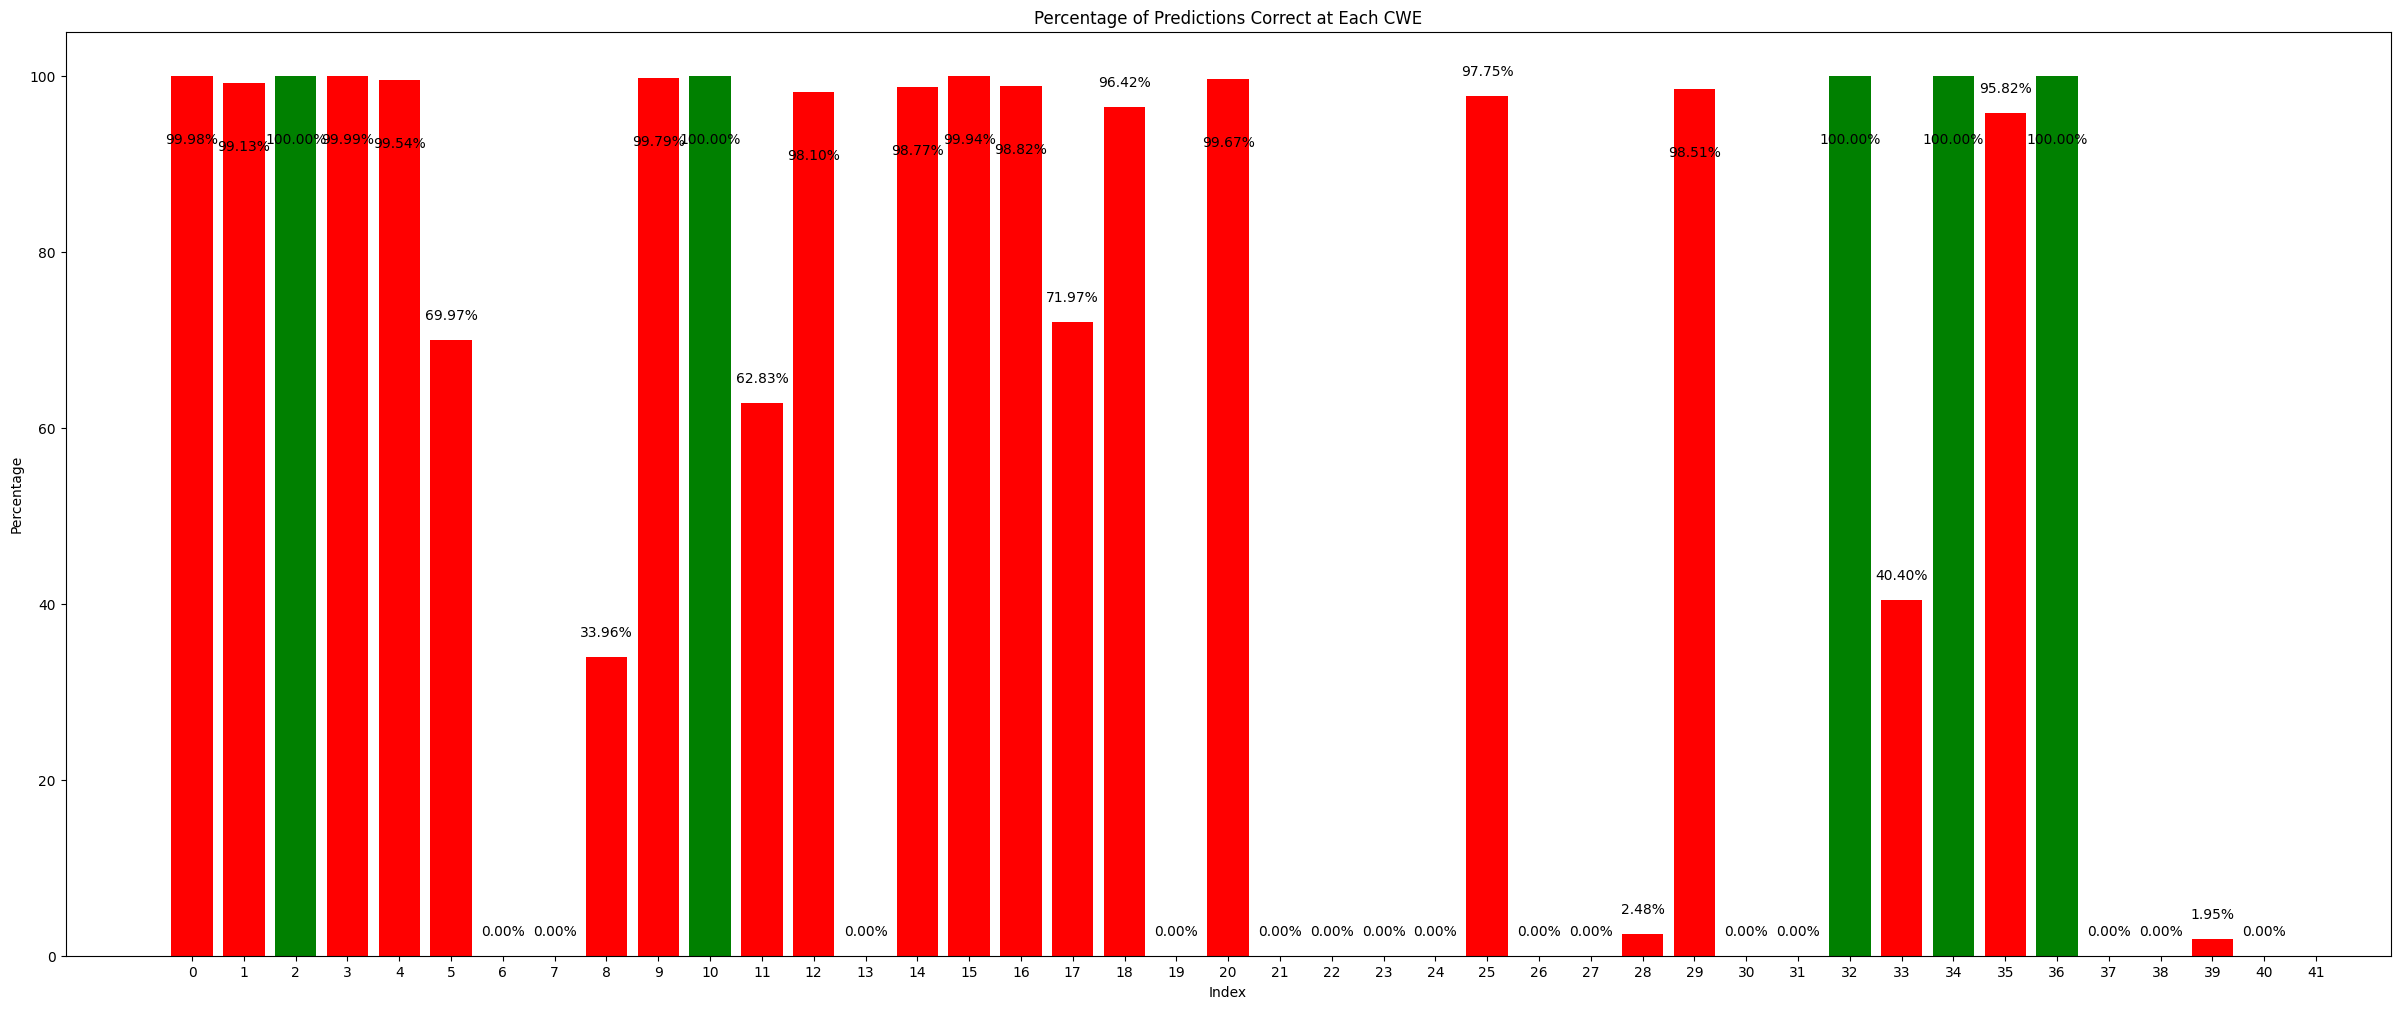

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = predictions * 100.0 / labels

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(30, 12))
ax.bar(range(len(labels)), percentages, color=['green' if p == 100 else 'red' for p in percentages])
ax.set_xlabel('Index')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each CWE')

ax.set_xticks(range(0, len(labels) + 1))

# Display the percentage on top of the bars with adjusted position
for i, v in enumerate(percentages):
    text_position = v + 2 if v < 98 else v - 8  # Adjust the position based on the value
    ax.text(i, text_position, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.show()


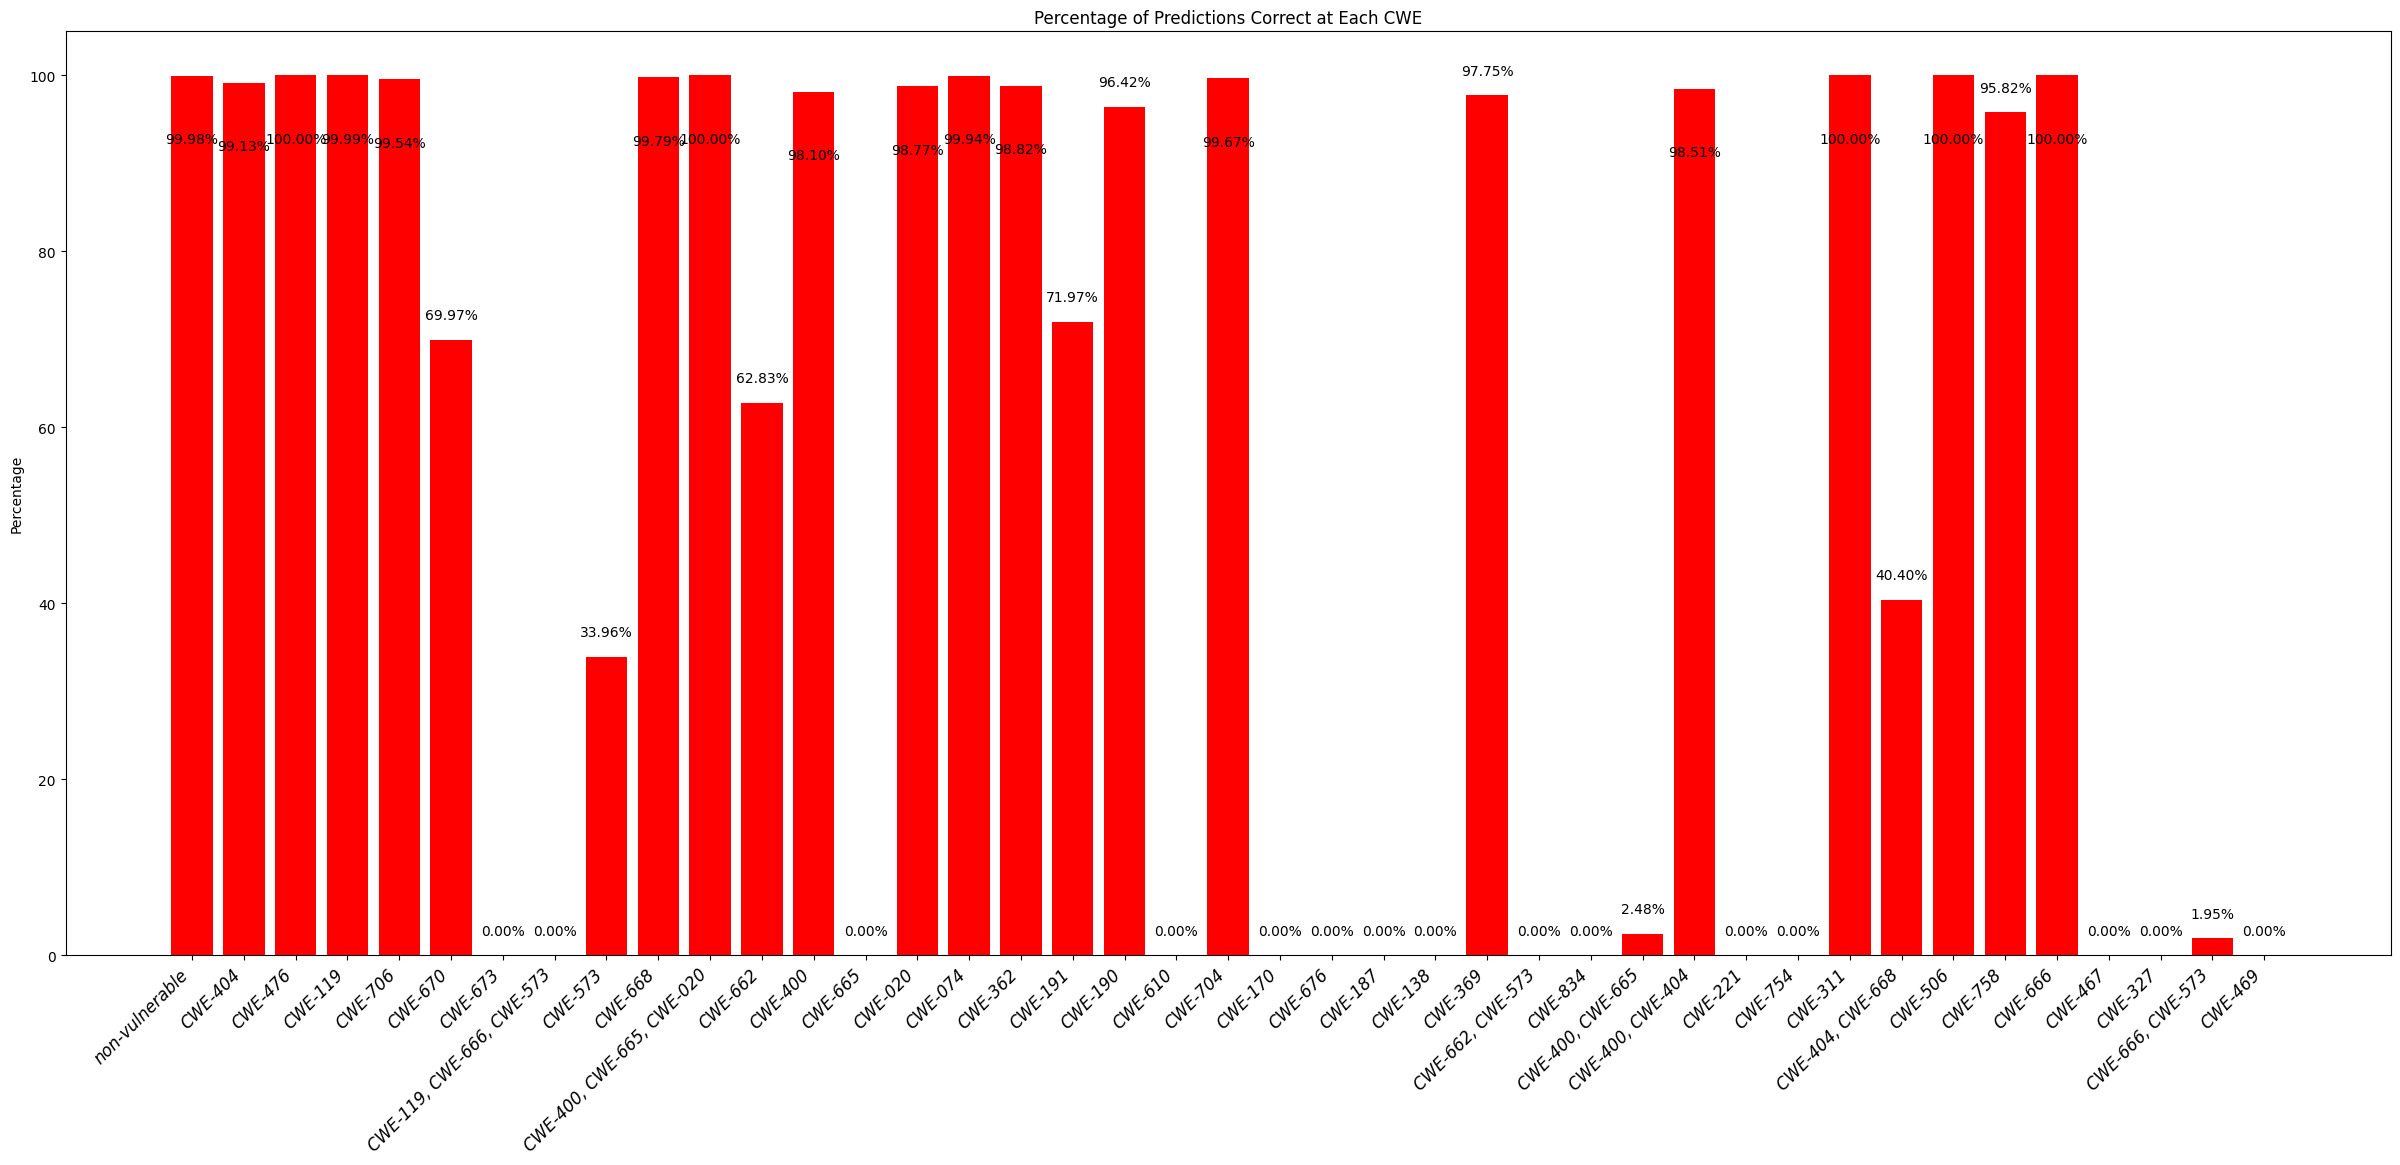

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = predictions * 100.0 / labels

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(30, 12))
ax.bar(range(1, len(labels) + 1), percentages, color=['red'])

# Set x-ticks to display values from 1 to 40 with "CWE" prefix
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(
    ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
    , rotation=45, ha='right', fontsize=12, fontstyle='italic')

ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each CWE')

# Display the percentage on top of the bars with adjusted position
for i, v in enumerate(percentages):
    text_position = v + 2 if v < 98 else v - 8  # Adjust the position based on the value
    ax.text(i + 1, text_position, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.show()
